In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit


In [107]:

def exponential_model(x, a, b, c):
    return a + b * np.exp(c * x)



def fit_exponential(x_data, y_data, abs_threshold=1e-16, fn=""):
    # Clean the data: replace near-zero with a threshold to avoid log-scale issues
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    y_data = np.where(np.abs(y_data) < abs_threshold, abs_threshold, y_data)

    # Initial guess for parameters: a, b, c
    initial_guess = [np.max(y_data), x_data[-1]*1e-5, -np.max(y_data)/10]

    try:
        popt, _ = curve_fit(exponential_model, x_data, y_data, p0=initial_guess);#, method='trf')#, maxfev=10000)
        a, b, c = popt;
        # print("fit:")
        # print(f"{a:.2e} + {b:.2e} * exp({c:.2e}  x)")
        # print(f"{initial_guess[0]:.2e} + {initial_guess[1]:.2e} * exp({initial_guess[2]:.2e}  x)")
        fitted_y = exponential_model(np.Inf, *popt);
        if fn:
            x = np.linspace(min(x_data)*0.85, max(x_data)*1.05)
            plt.figure()
            plt.plot(x_data, y_data, 'bo', label="Original data")
            plt.plot(x, exponential_model(x, *popt), 'r-', label="Fitted: a + b * exp(c * x)")
            plt.legend()
            plt.title("Exponential Fit")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.grid(True)
            plt.savefig(fn)
            plt.close()
        return fitted_y
    except RuntimeError as e:
        print(f"Fit failed: {e}")
        return np.full_like(x_data, np.nan)



def read_or_read(model, nq, nl, tstep, obs_i, obs_j, max_weight, min_abs_coeff, run=False):
    """
    Use existing data if present or fails.
    """
    fn = f"data/{model}_nq={nq}_nl={nl}_theta={tstep:.3e}_obsi={obs_i}_obsj={obs_j}_maxweight={max_weight}_minabscoeff={min_abs_coeff:.4e}_termcount.dat"
    expectation = 0
    terms_nbr = 0
    # observable = PauliString(nq, ['Z', 'Z'], [obs_i, obs_j])
    # time = np.linspace(tstep, tstep * nl, nl)

    try:
        assert not run
        data = pd.read_csv(fn)
        time_file = data.iloc[:, 0].values
        expectation = data.iloc[:, 1].values
        terms_nbr = data.iloc[:, 2].values
    except Exception as e:
        print("Error")
        return -1
    return expectation, terms_nbr


def zte_exp(expvals, terms_nbr, times, plotting=True, exact_expvals=None, abs_threshold=1e-16, fn="", last_element=0):
    assert len(expvals) == len(terms_nbr), f"The length of input arguments don't match (expvals={len(expvals)}, terms_nbr={len(terms_nbr)})"

    # fig1, ax1 = plt.subplots(1, 1)
    # fig2, ax2 = plt.subplots(1, 1)
    # corrected_expvals = []
    for k in range(last_element, -1, -1):
        corrected_expvals = []
        for idx in range(len(expvals[0])):
            expvals_t = expvals[:len(expvals) - k, idx]
            terms_nbr_t = terms_nbr[:len(expvals) - k, idx]

            # print(f"expvals_t: {expvals_t}")
            # print(f"terms_nbr_t: {terms_nbr_t}")

            corrected = fit_exponential(terms_nbr_t, expvals_t, abs_threshold=abs_threshold, fn="plot_fits/"+fn+f"_step={idx}_mostprecise={terms_nbr_t[-1]}.png")
            corrected_expvals.append(corrected)

        if plotting:
            truncated_most_precise = expvals[len(expvals) - k-1:len(expvals) - k][0]
            assert len(times) == len(corrected_expvals) == len(truncated_most_precise), \
                f"Lengths don't match: times={len(times)}, corrected={len(corrected_expvals)}, truncated={len(truncated_most_precise)}"

            def replace_zeros(arr):
                return np.where(np.abs(arr) < 1e-16, 1e-16, arr)

            corrected_expvals_cleaned = replace_zeros(np.array(corrected_expvals))
            truncated_cleaned = replace_zeros(np.array(truncated_most_precise))
            fig1, ax1 = plt.subplots(1, 1)
            # print(corrected_expvals)
            ax1.plot(times, corrected_expvals_cleaned, label="corrected", marker='o')
            ax1.plot(times, truncated_cleaned, label=f"{terms_nbr_t[-1]} terms", marker='o')
            ax1.set_xlabel("Time")
            ax1.set_ylabel("Observable")
            ax1.set_title(f"Evolution over time")
            ax1.legend()
            plt.show()

            if exact_expvals is not None:
                exact_cleaned = replace_zeros(np.array(exact_expvals))
                rel_err_corr = np.abs((corrected_expvals_cleaned - exact_cleaned) / exact_cleaned)
                rel_err_trunc = np.abs((truncated_cleaned - exact_cleaned) / exact_cleaned)
                
                fig2, ax2 = plt.subplots(1, 1)
           
                ax2.plot(times, rel_err_corr, label="corrected", marker='o')
                ax2.plot(times, rel_err_trunc, label="truncated most precise", marker='o')
                ax2.set_yscale('log')
                ax2.set_xlabel("Timestep")
                ax2.set_ylabel("Relative error")
                ax2.set_title(f"Evolution over time (at most {terms_nbr_t[-1]} terms)")
                ax2.legend()
                plt.show()
    plt.show()
    return corrected_expvals


In [108]:

data = pd.read_csv("data/exact_TFIM_nq=30_nl=30_theta=1.000e-02_obsi=21_obsj=20.dat")
time_file = data.iloc[:, 0].values
exact_expectation = data.iloc[:, 1].values

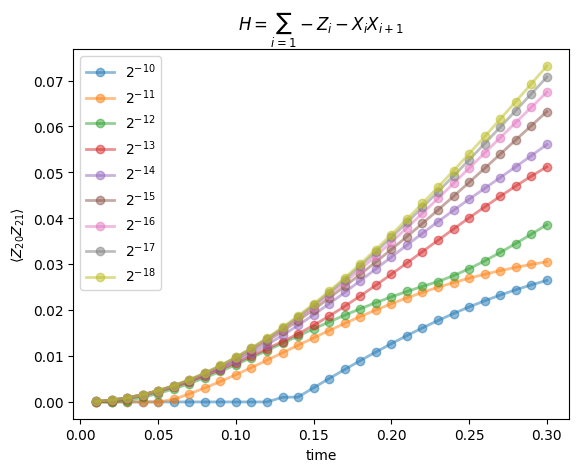

/tmp/ipykernel_601009/1737767802.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exponential_model, x_data, y_data, p0=initial_guess);#, method='trf')#, maxfev=10000)
/tmp/ipykernel_601009/1737767802.py:2: RuntimeWarning: overflow encountered in exp
  return a + b * np.exp(c * x)


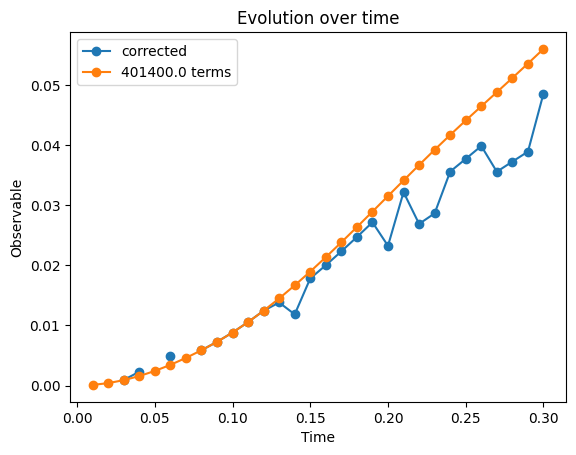

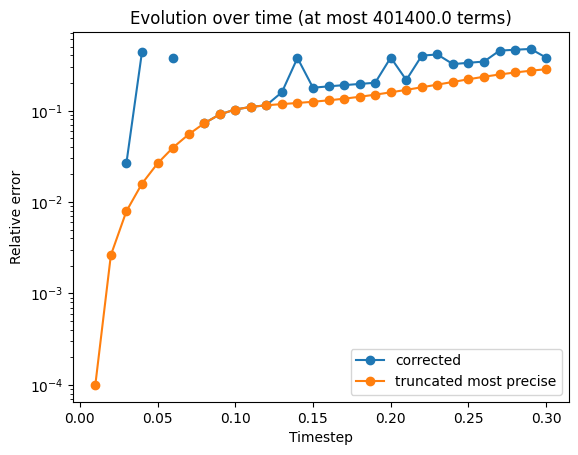

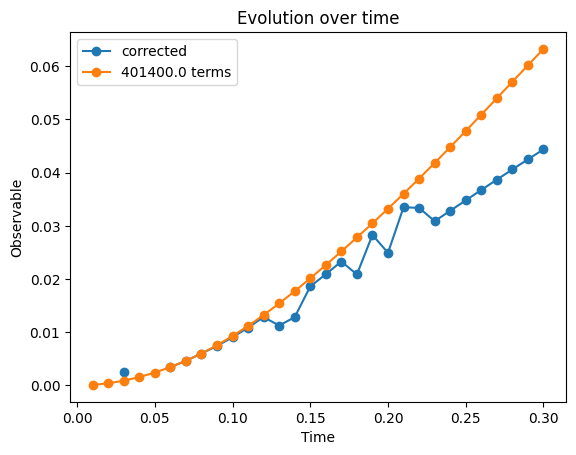

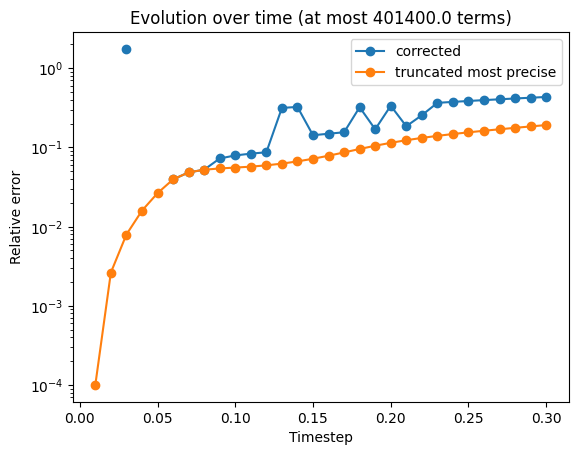

/tmp/ipykernel_601009/1737767802.py:2: RuntimeWarning: overflow encountered in multiply
  return a + b * np.exp(c * x)


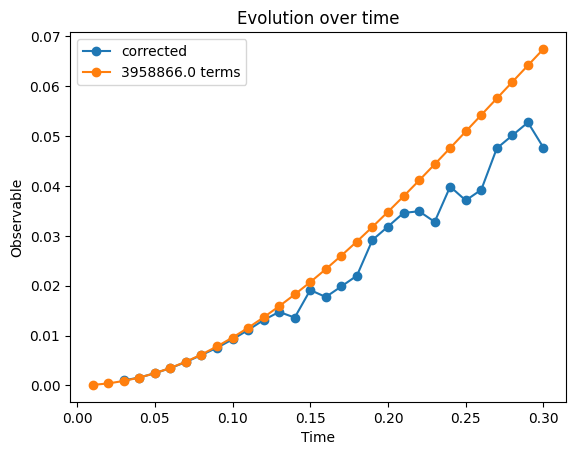

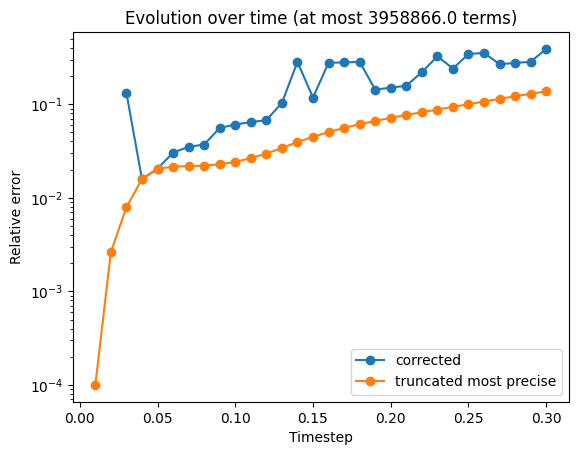

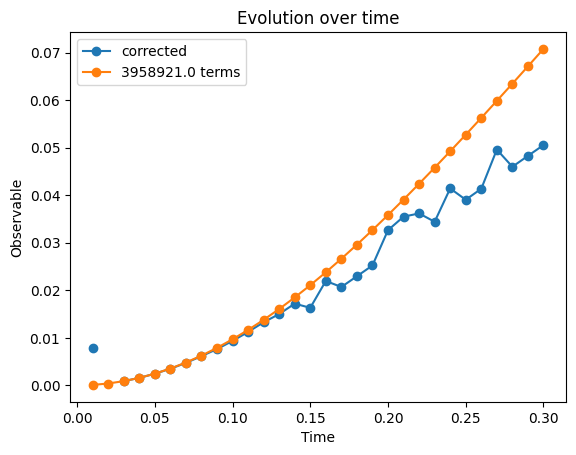

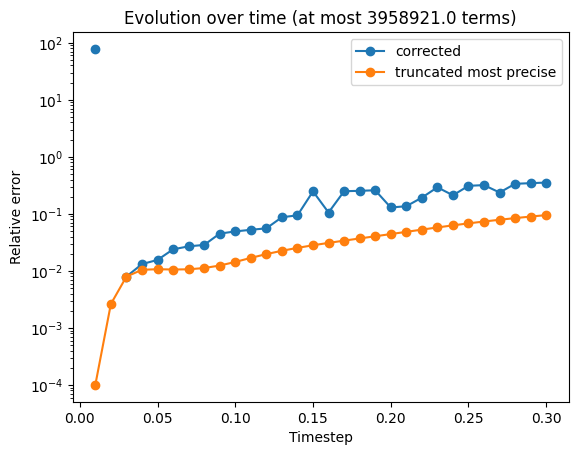

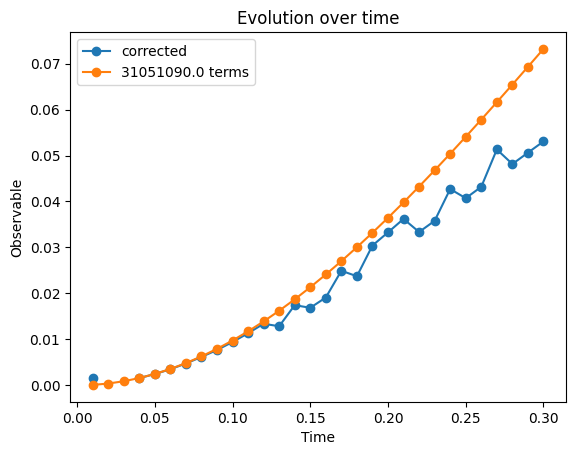

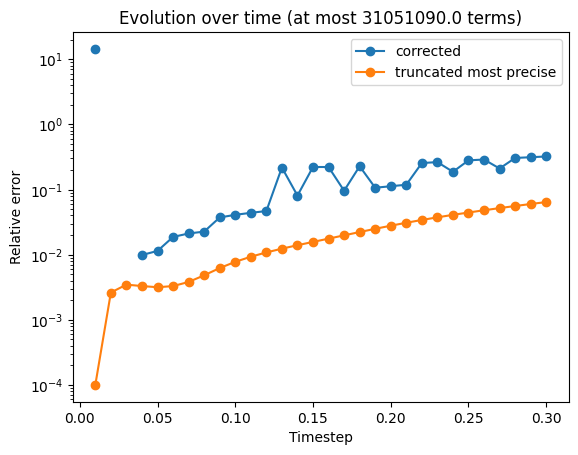

[0.001540636937574617,
 inf,
 inf,
 0.0015799933314984,
 0.0024612029280100998,
 0.003511592912094137,
 0.004757557272741282,
 0.006189425977238311,
 0.0076944059855061035,
 0.009433799000249102,
 0.011340329022634854,
 0.01340521993528706,
 0.012860202935603254,
 0.017447547658843866,
 0.016876944697721743,
 0.01911074906652272,
 0.02492816428540965,
 0.02374159708627581,
 0.030419762190143102,
 0.033282684637901336,
 0.036208322553720446,
 0.03336178761145417,
 0.035792303519818124,
 0.04270798892162871,
 0.04071542937085863,
 0.04319326235336633,
 0.051312724385602575,
 0.04814847336344759,
 0.05061418526238359,
 0.053064369013979235]

In [110]:

# Example usage (pseudo-code style for undefined elements)

model = "TFIM"
theta = 0.01j
θ = theta

nq = 30
nl = 30

# topology = bricklayertopology(nq)  # assumed predefined
# layerTFIM = []
# layerTFIM.extend(PauliRotation('Z', ii, θ) for ii in range(1, nq + 1))
# layerTFIM.extend(PauliRotation(['X', 'X'], pair, θ) for pair in topology)

obs_i = 21
obs_j = 20
# observable = PauliString(nq, ['Z', 'Z'], [obs_i, obs_j])

max_weight = 12
trunc_coeffs = 2.0 ** np.arange(-10, -19, -1)
tstep = 0.01
time = np.linspace(tstep, tstep * nl, nl)

fn = f"{model}_nq={nq}_nl={nl}_theta={tstep:.3e}_obsi={obs_i}_obsj={obs_j}_maxweight={max_weight}"

# Exact expectation
# M = jordan_wigner_tfim(nq, 1.0, 0.0, 1.0)
# zz = np.array([zz_correlation(M, t, obs_i, obs_j) for t in time])

# Truncated expectations
expvals = []
terms_nbrs = []

plt.figure()
plt.xlabel("time")
plt.ylabel(r"$\langle Z_{20}Z_{21} \rangle$")
plt.title(r"$H = \sum_{i=1} -Z_i - X_iX_{i+1}$")

for j in trunc_coeffs:
    expectation, terms_nbr = read_or_read(model, nq, nl, tstep, obs_i, obs_j, max_weight, j)
    expectation = np.where(np.array(expectation) == 0, 1e-16, expectation)

    plt.plot(time, expectation, label=f"$2^{{{int(np.log2(j))}}}$", lw=2, marker='o', alpha=0.5)
    expvals.append(expectation)
    terms_nbrs.append(terms_nbr)

# plt.plot(time, zz, label="exact", color="red", lw=2, marker='o', alpha=0.5)
plt.legend()
plt.show()

zte_exp(np.array(expvals), np.array(terms_nbrs), time, exact_expvals=exact_expectation, fn=fn, last_element=4)


Error


TypeError: cannot unpack non-iterable int object

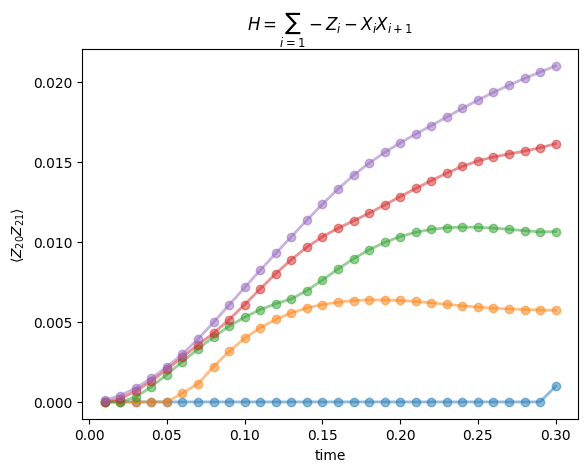

In [106]:

# Example usage (pseudo-code style for undefined elements)

model = "XXZ_J=3.0"
theta = 0.01j
θ = theta

nq = 30
nl = 30

# topology = bricklayertopology(nq)  # assumed predefined
# layerTFIM = []
# layerTFIM.extend(PauliRotation('Z', ii, θ) for ii in range(1, nq + 1))
# layerTFIM.extend(PauliRotation(['X', 'X'], pair, θ) for pair in topology)

obs_i = 21
obs_j = 20
# observable = PauliString(nq, ['Z', 'Z'], [obs_i, obs_j])

max_weight = 12
trunc_coeffs = 2.0 ** np.arange(-10, -19, -1)
tstep = 0.01
time = np.linspace(tstep, tstep * nl, nl)

fn = f"{model}_nq={nq}_nl={nl}_theta={tstep:.3e}_obsi={obs_i}_obsj={obs_j}_maxweight={max_weight}"

# Exact expectation
# M = jordan_wigner_tfim(nq, 1.0, 0.0, 1.0)
# zz = np.array([zz_correlation(M, t, obs_i, obs_j) for t in time])

# Truncated expectations
expvals = []
terms_nbrs = []

plt.figure()
plt.xlabel("time")
plt.ylabel(r"$\langle Z_{20}Z_{21} \rangle$")
plt.title(r"$H = \sum_{i=1} -Z_i - X_iX_{i+1}$")

for j in trunc_coeffs:
    expectation, terms_nbr = read_or_read(model, nq, nl, tstep, obs_i, obs_j, max_weight, j)
    expectation = np.where(np.array(expectation) == 0, 1e-16, expectation)

    plt.plot(time, expectation, label=f"$2^{{{int(np.log2(j))}}}$", lw=2, marker='o', alpha=0.5)
    expvals.append(expectation)
    terms_nbrs.append(terms_nbr)

# plt.plot(time, zz, label="exact", color="red", lw=2, marker='o', alpha=0.5)
plt.legend()
plt.show()

zte_exp(np.array(expvals), np.array(terms_nbrs), time, exact_expvals=None, fn=fn, last_element=4)


In [96]:
np.array(expvals)

array([[1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
        1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
        1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
        1.00980615e-03, 1.05369845e-03, 3.09053634e-03, 5.09588394e-03,
        7.06558482e-03, 8.99347492e-03, 1.08721156e-02, 1.26934718e-02,
        1.44495180e-02, 1.61327528e-02, 1.77366073e-02, 1.92557396e-02,
        2.06862150e-02, 2.20255798e-02, 2.32728422e-02, 2.44283803e-02,
        2.54937956e-02, 2.64717325e-02],
       [1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
        1.00000000e-16, 5.66762650e-04, 1.74797852e-03, 3.04776744e-03,
        4.44968883e-03, 5.93585620e-03, 7.48733716e-03, 9.08462784e-03,
        1.07081758e-02, 1.23389185e-02, 1.39588015e-02, 1.55512404e-02,
        1.71014988e-02, 1.85969616e-02, 2.00272933e-02, 2.13844847e-02,
        2.26627963e-02, 2.38586170e-02, 2.49702585e-02, 2.59977082e-02,
        2.69423605e-02,